In [1]:
import numpy as np
import matplotlib.pyplot as plt
from architecture.Model import Model
from dataloader.Dataloader import *
from train.Trainer import *
import torch
from munch import Munch
from evaluation.Evaluator import Evaluator
from torchvision.utils import make_grid

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/balt/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
#argparser doesnt work for jupyter notebook
model_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'style_dim': 64,
    'num_domains' : 2, #celeba
    'fan_pretrained_fname' : "architecture/FAN/weights.pth",
    "wFilter" : 1 # 0<= -> no FAN
})

In [3]:
#load trained networks
nets, _ = Model(model_params) #instantiate model
cpt = torch.load("runs/celeba_model/000010__networs_copy.cpt") #take the copy weights -> moving average improves quality

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model_name, model in nets.items():
    print(model_name)
    if model_name in cpt:
        model.load_state_dict(cpt[model_name])
        model.eval().to(device)

generator
mapping_network
style_encoder
discriminator
fan


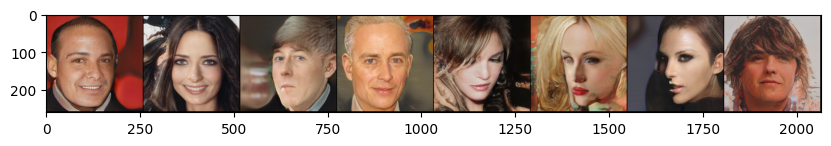

In [5]:
#test if weight upload worked correctly
root = "../shared/stargan_folder/data/celeba_hq/train" #if gpu server

train_loader = get_loader(root, 8, model_params.img_size)


train_fetcher=Fetcher(train_loader)
inputs = next(train_fetcher)
x_org,y_org = inputs.x, inputs.y
z1, z2 = inputs.z1, inputs.z2
x_ref1, x_ref2 = inputs.x_ref1, inputs.x_ref2
y_trg = inputs.y_trg

generator = nets.generator
mn = nets.mapping_network

style = mn(z1,y_trg)
input_img=x_org
masks = nets.fan.get_heatmap(input_img) if model_params.wFilter>0 else None
x_fake=generator(input_img,style,masks)

x_n = [(x-x.min())/(x.max()-x.min()) for x in x_fake]
#normalize_tensor(x_fake)

grid = make_grid(x_n)



imgs=torch.permute(grid, [1,2,0]).cpu().detach().numpy()
#save_image(grid,"test.png")


#fake_img=torch.permute((x_fake+1)/2, [1,2,0]).cpu().detach().numpy()

plt.figure(figsize=(10,5))
plt.imshow(imgs)
plt.show()

In [5]:
#argparser doesnt work for jupyter notebook
eval_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'batch_size': 32,
    'num_outputs' : 10,
    "wFilter" : 1, # 0<= -> no FAN
    "val_dir" : "../shared/stargan_folder/data/celeba_hq/val",
    "train_dir" : "../shared/stargan_folder/data/celeba_hq/train",
    "save_dir" : "eval"
})

In [6]:
evaluator = Evaluator(eval_params, nets)

In [7]:
#evaluator.evaluate_lpips(mode="latent")

male to female generation
female to male generation


{'male2female': array(0.5098303, dtype=float32),
 'female2male': array(0.5236599, dtype=float32),
 'LPIPS_latent/mean': 0.5167450904846191}

In [7]:
#evaluator.evaluate_lpips(mode="reference")

male to female generation
female to male generation


{'male2female': array(0.42272726, dtype=float32),
 'female2male': array(0.42590123, dtype=float32),
 'LPIPS_reference/mean': 0.4243142455816269}

In [7]:
evaluator.evaluate_fid(mode="latent",step=0)

male to female generation
Real Path ../shared/stargan_folder/data/celeba_hq/train/female 	 path_fake eval/latent/male2female...
real images


100%|██████████| 204/204 [16:52<00:00,  4.96s/it]


fake images


100%|██████████| 168/168 [13:34<00:00,  4.85s/it]


female to male generation
Real Path ../shared/stargan_folder/data/celeba_hq/train/male 	 path_fake eval/latent/female2male...
real images


100%|██████████| 314/314 [25:42<00:00,  4.91s/it]


fake images


100%|██████████| 310/310 [25:55<00:00,  5.02s/it]


In [8]:
evaluator.evaluate_fid(mode="reference",step=0)

male to female generation
Real Path ../shared/stargan_folder/data/celeba_hq/train/female 	 path_fake eval/reference/male2female...
real images


100%|██████████| 204/204 [16:08<00:00,  4.75s/it]


fake images


100%|██████████| 310/310 [23:47<00:00,  4.60s/it]


female to male generation
Real Path ../shared/stargan_folder/data/celeba_hq/train/male 	 path_fake eval/reference/female2male...
real images


100%|██████████| 314/314 [22:41<00:00,  4.34s/it]


fake images


100%|██████████| 310/310 [18:13<00:00,  3.53s/it]


AFHQ

In [11]:
#argparser doesnt work for jupyter notebook
model_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'style_dim': 64,
    'num_domains' : 3, #celeba
    'fan_pretrained_fname' : "architecture/FAN/weights.pth",
    "wFilter" : 0 # 0<= -> no FAN
})

In [12]:
#load trained networks
nets, _ = Model(model_params) #instantiate model
cpt = torch.load("runs/afhq_model/000010__networs_copy.cpt") #take the copy weights -> moving average improves quality

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model_name, model in nets.items():
    print(model_name)
    if model_name in cpt:
        model.load_state_dict(cpt[model_name])
        model.eval().to(device)

generator
mapping_network
style_encoder
discriminator


In [17]:
#argparser doesnt work for jupyter notebook
eval_params = Munch({
    'img_size': 256, #256
    'latent_dim': 16,
    'batch_size': 32,
    'num_outputs' : 10,
    "wFilter" : 0, # 0<= -> no FAN
    "val_dir" : "../shared/stargan_folder/data/afhq/val",
    "train_dir" : "../shared/stargan_folder/data/afhq/train",
    "save_dir" : "eval"
})

In [18]:
evaluator = Evaluator(eval_params, nets)

In [19]:
evaluator.evaluate_lpips(mode="latent")

dog to cat generation
wild to cat generation
cat to dog generation
wild to dog generation
cat to wild generation
dog to wild generation


{'dog2cat': array(0.58963954, dtype=float32),
 'wild2cat': array(0.57994574, dtype=float32),
 'cat2dog': array(0.59454405, dtype=float32),
 'wild2dog': array(0.588575, dtype=float32),
 'cat2wild': array(0.55877763, dtype=float32),
 'dog2wild': array(0.568961, dtype=float32),
 'LPIPS_latent/mean': 0.5800738334655762}

In [22]:
evaluator.evaluate_lpips(mode="reference")

dog to cat generation
wild to cat generation


UnboundLocalError: local variable 'ref_fetcher' referenced before assignment

In [ ]:
evaluator.evaluate_fid(mode="latent",step=1)

In [ ]:
evaluator.evaluate_fid(mode="reference",step=1)